## Dataset import

In [ ]:
import dython

In [ ]:
# imports - [need to double-run]
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import datetime as dt

# data manipulation
import pandas as pd
import numpy as np

# data viz
#!python -m pip uninstall dython
#!pip install dython
#!python -m pip uninstall scipy
#!pip install scipy
#!pip install dython
#import scipy
#def someFunction(arg):
#    import dython.nominal
#from dython.nominal import associations
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# apply some cool styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12,  6)

In [ ]:
# mounting the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing SCVIC2021 data

%cd /content/drive/MyDrive/Colab Notebooks/

train = pd.read_csv("Training.csv")
test = pd.read_csv("Testing.csv")

/content/drive/MyDrive/Colab Notebooks


In [ ]:
dataset = pd.concat([train, test])
dataset['Label'].value_counts()

NormalTraffic        310419
Pivoting               2482
Reconnaissance         1084
LateralMovement         871
DataExfiltration        601
InitialCompromise       150
Name: Label, dtype: int64

In [ ]:
# dropping NaNs and infs from all tables for drawing matrixes

test = test.replace(np.inf, None)
test = test.dropna().reset_index(drop = True)

train = train.replace(np.inf, None)
train = train.dropna().reset_index(drop = True)

dataset = dataset.replace(np.inf, None)
dataset = dataset.dropna().reset_index(drop = True)

In [ ]:
# RUS combined dataset for faster computations - US only normaltraffic method

normal_labels = dataset.loc[dataset['Label'] == 'NormalTraffic']
nl = normal_labels.sample(10000, random_state=0)
dataset1 = dataset.loc[dataset['Label'] != 'NormalTraffic']
dataset2 = pd.concat([dataset1, nl])
dataset2['Label'].value_counts()

NormalTraffic        10000
Pivoting              2482
Reconnaissance        1084
LateralMovement        869
DataExfiltration       601
InitialCompromise      150
Name: Label, dtype: int64

In [ ]:
test['Label'].value_counts()

NormalTraffic        55024
Pivoting               360
Reconnaissance         251
LateralMovement        141
InitialCompromise       77
DataExfiltration        74
Name: Label, dtype: int64

In [ ]:
test.sample(10000)['Label'].value_counts()

NormalTraffic        9838
Pivoting               79
Reconnaissance         36
LateralMovement        24
InitialCompromise      14
DataExfiltration        9
Name: Label, dtype: int64

## Correlation matrix

### Original

In [ ]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

In [ ]:
d1 = dython.nominal.associations(dataset2, cmap="Spectral_r", figsize=(50,50), nan_strategy = 'drop_samples')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
corr_df = d1['corr']

# drop where absolute value of the correlation coefficient of any metric with a label is <= 0.2
threshold = 0.35

indexes = corr_df.loc[(abs(corr_df['Label']) > threshold)]['Label'].index
len(indexes)

25

In [ ]:
corr_df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Flow ID,1.000000,0.759119,1.000000,0.759496,1.000000,1.000000,0.000000,0.845040,0.389450,0.762524,...,0.999374,0.252513,0.0,0.252513,0.252513,0.634999,0.541837,0.999759,0.551908,0.423237
Src IP,0.759119,1.000000,0.860004,0.731419,0.608572,0.848860,0.442528,0.711117,0.341189,0.666012,...,0.967743,0.152687,0.0,0.152687,0.152687,0.470033,0.282457,0.999759,0.304667,0.595782
Src Port,1.000000,0.860004,1.000000,0.852704,-0.077757,-0.361884,0.776578,-0.015680,0.064676,0.202155,...,0.496572,0.011183,0.0,0.011183,0.011183,-0.003262,-0.039214,-0.077359,0.017692,0.221896
Dst IP,0.759496,0.731419,0.852704,1.000000,0.727383,0.773221,0.330265,0.593063,0.345000,0.693198,...,0.883365,0.152853,0.0,0.152853,0.152853,0.466496,0.275323,0.999756,0.298217,0.647707
Dst Port,1.000000,0.608572,-0.077757,0.727383,1.000000,0.180250,0.629809,-0.140096,-0.005709,0.005379,...,0.055241,0.008532,0.0,0.008532,0.008532,0.083889,0.016133,0.193978,0.037311,0.040781


In [ ]:
corr_df1 = corr_df.drop(['Flow Bytes/s', 'Flow Packets/s'], axis = 1)
corr_df1 = corr_df.drop(columns = ['Flow Bytes/s', 'Flow Packets/s'])

In [ ]:
indexes1 = indexes.drop(['Flow Bytes/s', 'Flow Packets/s'])
len(indexes1)

23

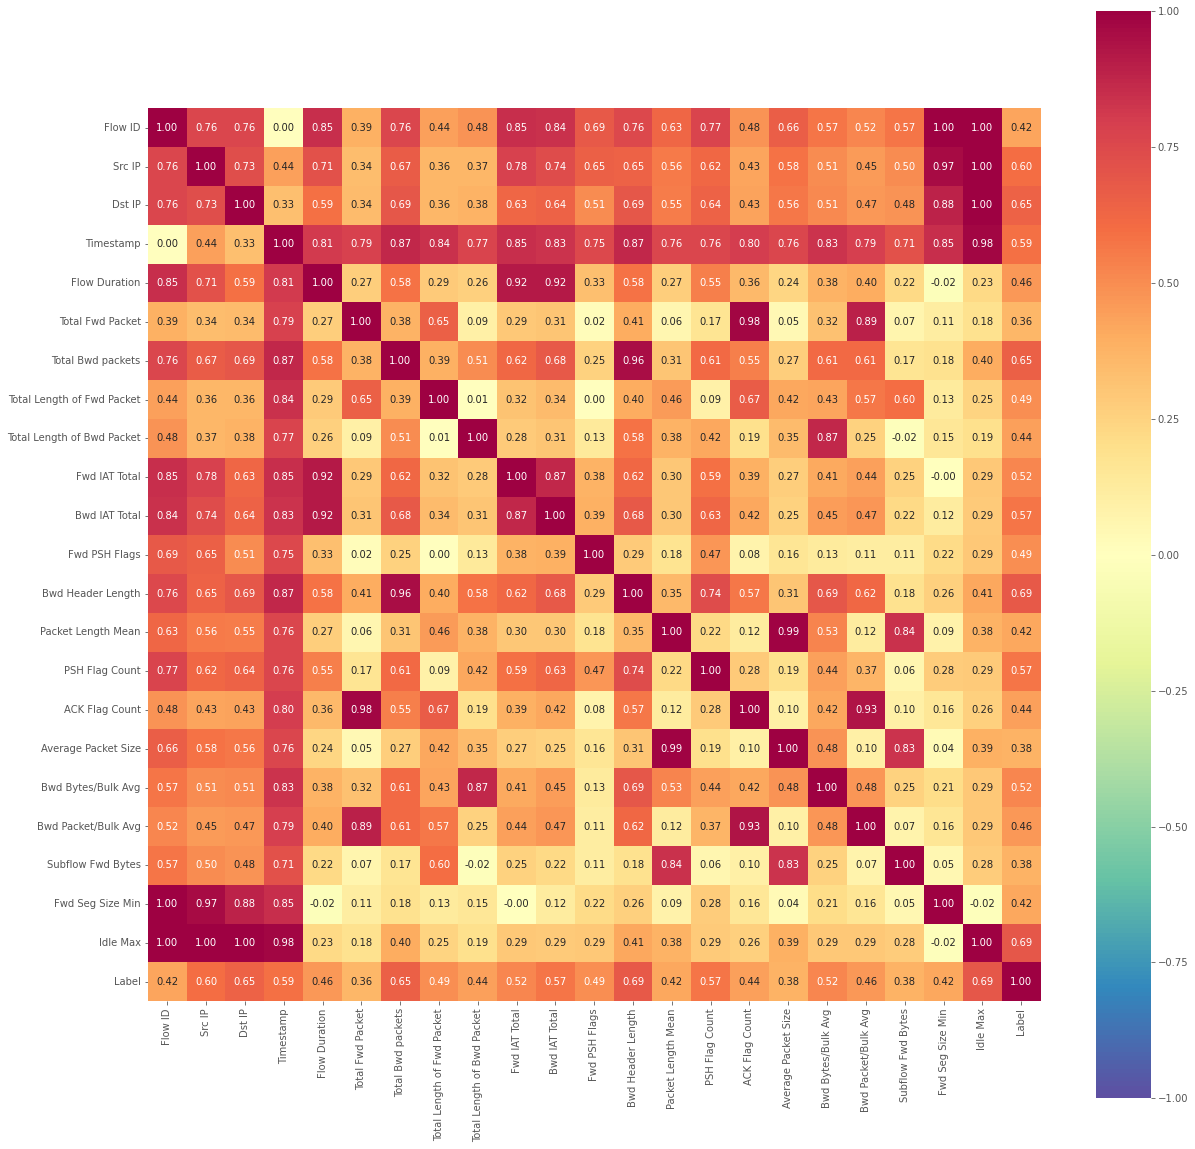

In [ ]:
plt.figure(figsize = (20, 20))
hm = sns.heatmap(corr_df1.loc[indexes1, indexes1], 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 vmin = - 1.0,
                 vmax = 1.0,
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=indexes1, 
                 xticklabels=indexes1, 
                 cmap="Spectral_r")

### Reconnaissance

In [ ]:
# making initial compromise phase centric dataset
dataset_R = dataset2
dataset_R['Label'] = dataset_R['Label'].apply(lambda x: 'Attack' if x == 'Reconnaissance' else 'Benign')
print(dataset_R['Label'].value_counts())

d_R = associations(dataset_R, cmap="Spectral_r", figsize=(50,50), nan_strategy = 'drop_samples')

In [ ]:
corr_df = d_R['corr']

# drop where absolute value of the correlation coefficient of any metric with a label is <= 0.2
threshold = 0.1

indexes = corr_df.loc[(abs(corr_df['Label']) > threshold)]['Label'].index
len(indexes)

In [ ]:
plt.figure(figsize = (20, 20))
plt.title('Attack phase: Reconnaissance\nthreshold = 0.1    num_attributes = 11')
hm = sns.heatmap(corr_df.loc[indexes, indexes], 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 vmin = -0.6,
                 vmax = 1.0,
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=indexes, 
                 xticklabels=indexes, 
                 cmap="Spectral_r")

### Initial Compromise

In [ ]:
normal_labels = dataset.loc[dataset['Label'] == 'NormalTraffic']
nl = normal_labels.sample(100000, random_state=0)
dataset1 = dataset.loc[dataset['Label'] != 'NormalTraffic']
dataset2 = pd.concat([dataset1, nl])
dataset2['Label'].value_counts()

In [ ]:
# making initial compromise phase centric dataset
dataset_IC = dataset2
dataset_IC['Label'] = dataset_IC['Label'].apply(lambda x: 'Attack' if x == 'InitialCompromise' else 'Benign')
print(dataset_IC['Label'].value_counts())

d_IC = associations(dataset_IC, cmap="Spectral_r", figsize=(50,50), nan_strategy = 'drop_samples')

In [ ]:
corr_df = d_IC['corr']

# drop where absolute value of the correlation coefficient of any metric with a label is <= 0.2
threshold = 0.1

indexes = corr_df.loc[(abs(corr_df['Label']) > threshold)]['Label'].index
len(indexes)

In [ ]:
plt.figure(figsize = (20, 20))
plt.title('Attack phase: InitialCompromise\nthreshold = 0.1    num_attributes = 14')
hm2 = sns.heatmap(corr_df.loc[indexes, indexes], 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 vmin = -0.6,
                 vmax = 1.0,
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=indexes, 
                 xticklabels=indexes, 
                 cmap="Spectral_r")

### Lateral Movement

In [ ]:
normal_labels = dataset.loc[dataset['Label'] == 'NormalTraffic']
nl = normal_labels.sample(100000, random_state=0)
dataset1 = dataset.loc[dataset['Label'] != 'NormalTraffic']
dataset2 = pd.concat([dataset1, nl])
dataset2['Label'].value_counts()

In [ ]:
# making initial compromise phase centric dataset
dataset_LM = dataset2
dataset_LM['Label'] = dataset_LM['Label'].apply(lambda x: 'Attack' if x == 'LateralMovement' else 'Benign')
print(dataset_LM['Label'].value_counts())

d_LM = associations(dataset_LM, cmap="Spectral_r", figsize=(50,50), nan_strategy = 'drop_samples')

In [ ]:
corr_df = d_LM['corr']

# drop where absolute value of the correlation coefficient of any metric with a label is <= 0.2
threshold = 0.2

indexes = corr_df.loc[(abs(corr_df['Label']) > threshold)]['Label'].index
len(indexes)

In [ ]:
plt.figure(figsize = (20, 20))
plt.title('Attack phase: LateralMovement\nthreshold = 0.2    num_attributes = 17')
hm2 = sns.heatmap(corr_df.loc[indexes, indexes], 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 vmin = -0.6,
                 vmax = 1.0,
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=indexes, 
                 xticklabels=indexes, 
                 cmap="Spectral_r")

### Data Exfiltration

In [ ]:
normal_labels = dataset.loc[dataset['Label'] == 'NormalTraffic']
nl = normal_labels.sample(100000, random_state=0)
dataset1 = dataset.loc[dataset['Label'] != 'NormalTraffic']
dataset2 = pd.concat([dataset1, nl])
dataset2['Label'].value_counts()

In [ ]:
# making initial compromise phase centric dataset
dataset_DE = dataset2
dataset_DE['Label'] = dataset_DE['Label'].apply(lambda x: 'Attack' if x == 'DataExfiltration' else 'Benign')
print(dataset_DE['Label'].value_counts())

d_DE = associations(dataset_DE, cmap="Spectral_r", figsize=(50,50), nan_strategy = 'drop_samples')

In [ ]:
corr_df = d_DE['corr']

# drop where absolute value of the correlation coefficient of any metric with a label is <= 0.2
threshold = 0.1

indexes = corr_df.loc[(abs(corr_df['Label']) > threshold)]['Label'].index
len(indexes)

In [ ]:
plt.figure(figsize = (20, 20))
plt.title('Attack phase: DataExfiltration\nthreshold = 0.1    num_attributes = 16')
hm2 = sns.heatmap(corr_df.loc[indexes, indexes], 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 vmin = -0.6,
                 vmax = 1.0,
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=indexes, 
                 xticklabels=indexes, 
                 cmap="Spectral_r")

### Pivoting

In [ ]:
normal_labels = dataset.loc[dataset['Label'] == 'NormalTraffic']
nl = normal_labels.sample(100000, random_state=0)
dataset1 = dataset.loc[dataset['Label'] != 'NormalTraffic']
dataset2 = pd.concat([dataset1, nl])
dataset2['Label'].value_counts()

In [ ]:
# making initial compromise phase centric dataset
dataset_P = dataset2
dataset_P['Label'] = dataset_P['Label'].apply(lambda x: 'Attack' if x == 'Pivoting' else 'Benign')
print(dataset_P['Label'].value_counts())

d_P = associations(dataset_P, cmap="Spectral_r", figsize=(50,50), nan_strategy = 'drop_samples')

In [ ]:
corr_df = d_P['corr']

# drop where absolute value of the correlation coefficient of any metric with a label is <= 0.2
threshold = 0.25

indexes = corr_df.loc[(abs(corr_df['Label']) > threshold)]['Label'].index
len(indexes)

In [ ]:
plt.figure(figsize = (20, 20))
plt.title('Attack phase: Pivoting\nthreshold = 0.25    num_attributes = 14')
hm2 = sns.heatmap(corr_df.loc[indexes, indexes], 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 vmin = -0.6,
                 vmax = 1.0,
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=indexes, 
                 xticklabels=indexes, 
                 cmap="Spectral_r")

### Ultimate plot